Automated Data Collected for 200 Runs - Historical Data

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import pandas as pd
import random
import re

# Set up the Selenium WebDriver with headless option
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--window-size=1920,1200')

service = Service(r"C:\Users\tashf\OneDrive\Desktop\chromedriver-win64\chromedriver-win64\chromedriver.exe") 
browser = webdriver.Chrome(service=service, options=options)
browser.get("http://www.randhawa.us/games/retailer/nyu.html")

# Function to get element by ID
def get_element_by_id(id):
    return browser.find_element(By.ID, id)

# Locate web elements
maintain_button = get_element_by_id("maintainButton")
drop_10_button = get_element_by_id("tenButton")
drop_20_button = get_element_by_id("twentyButton")
drop_40_button = get_element_by_id("fortyButton")
restart_button = browser.find_element(By.CLASS_NAME, "button")

# Functions to simulate different discount strategies
def apply_discount(strategy):
    for week in range(15):
        if strategy[week] == 'maintain':
            maintain_button.click()
        elif strategy[week] == '10%':
            drop_10_button.click()
        elif strategy[week] == '20%':
            drop_20_button.click()
        elif strategy[week] == '40%':
            drop_40_button.click()
        time.sleep(0.1)  # Reduced wait time

# Function to extract results from the webpage
def extract_results():
    week_data = []
    for week in range(1, 16):
        row = browser.find_element(By.XPATH, f'//tr[td[text()="{week}"]]')
        cols = row.find_elements(By.TAG_NAME, "td")
        week_data.append({
            "Week": int(cols[0].text),
            "Price": int(cols[1].text),
            "Sales": int(cols[2].text),
            "Remaining Inventory": int(cols[3].text)
        })

    revenue = int(re.sub(r'[^\d.]', '', get_element_by_id("rev").text))
    perfect_revenue = int(re.sub(r'[^\d.]', '', get_element_by_id("perfect").text))
    difference = float(re.sub(r'[^\d.]', '', browser.find_element(By.XPATH, '//*[contains(text(), "Difference:")]').text.split(":")[-1].strip().replace("%", "")))

    return week_data, revenue, perfect_revenue, difference

# Master list to store results from all games
all_results = []

# Number of games to play
n_games = 200

# Random strategy generator
def generate_ordered_strategy():
    strategy = ['maintain'] * 3  # Start with 3 weeks of maintaining price
    discounts = ['10%', '20%', '40%']
    remaining_weeks = 12

    for week in range(remaining_weeks):
        if discounts:
            choice = random.choice(['maintain'] + discounts)
            if choice in discounts:
                discounts.remove(choice)
        else:
            choice = 'maintain'
        strategy.append(choice)

    return strategy

# Play multiple games with different strategies
for run_number in range(1, n_games + 1):
    restart_button.click()
    time.sleep(0.1)  # Reduced wait time

    strategy = generate_ordered_strategy()
    apply_discount(strategy)

    week_data, revenue, perfect_revenue, difference = extract_results()

    for week in week_data:
        week.update({
            "Run": run_number,
            "Your Revenue": revenue,
            "Perfect Revenue": perfect_revenue,
            "Difference (%)": difference
        })
        all_results.append(week)

    print(f"Completed run {run_number} with strategy: {strategy}")

# Convert results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(all_results)
results_df.to_csv("retailer_game_results.csv", index=False)


This code automates the simulation of a retailer markdown game using the Selenium WebDriver in headless mode. It sets up the browser to run without a UI, locates necessary web elements, and applies various discount strategies over multiple runs. The strategy starts with maintaining the price for three weeks, then randomly applies one-time discounts of 10%, 20%, or 40%. Results are collected after each game run, including weekly sales data, total revenue, and comparison to an optimal strategy. Finally, the collected data is saved into a CSV file for further analysis.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [7]:
df = pd.read_csv("retailer_game_results.csv")
df.head()   

,Run,Week,Price,Sales,Remaining Inventory,Your Revenue,Perfect Revenue,Difference (%)
0,1,1,60,137,1863,89028,120000,25.8
1,1,2,60,162,1701,89028,120000,25.8
2,1,3,60,101,1600,89028,120000,25.8
3,1,4,60,178,1422,89028,120000,25.8
4,1,5,48,263,1159,89028,120000,25.8


Visualizing price points in dataset

<Axes: >

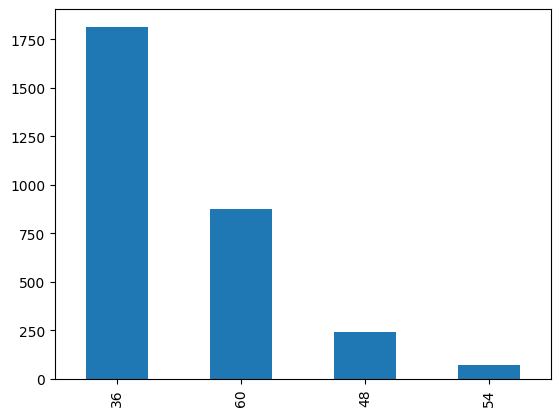

In [8]:
df['Price'].value_counts().plot(kind='bar') 

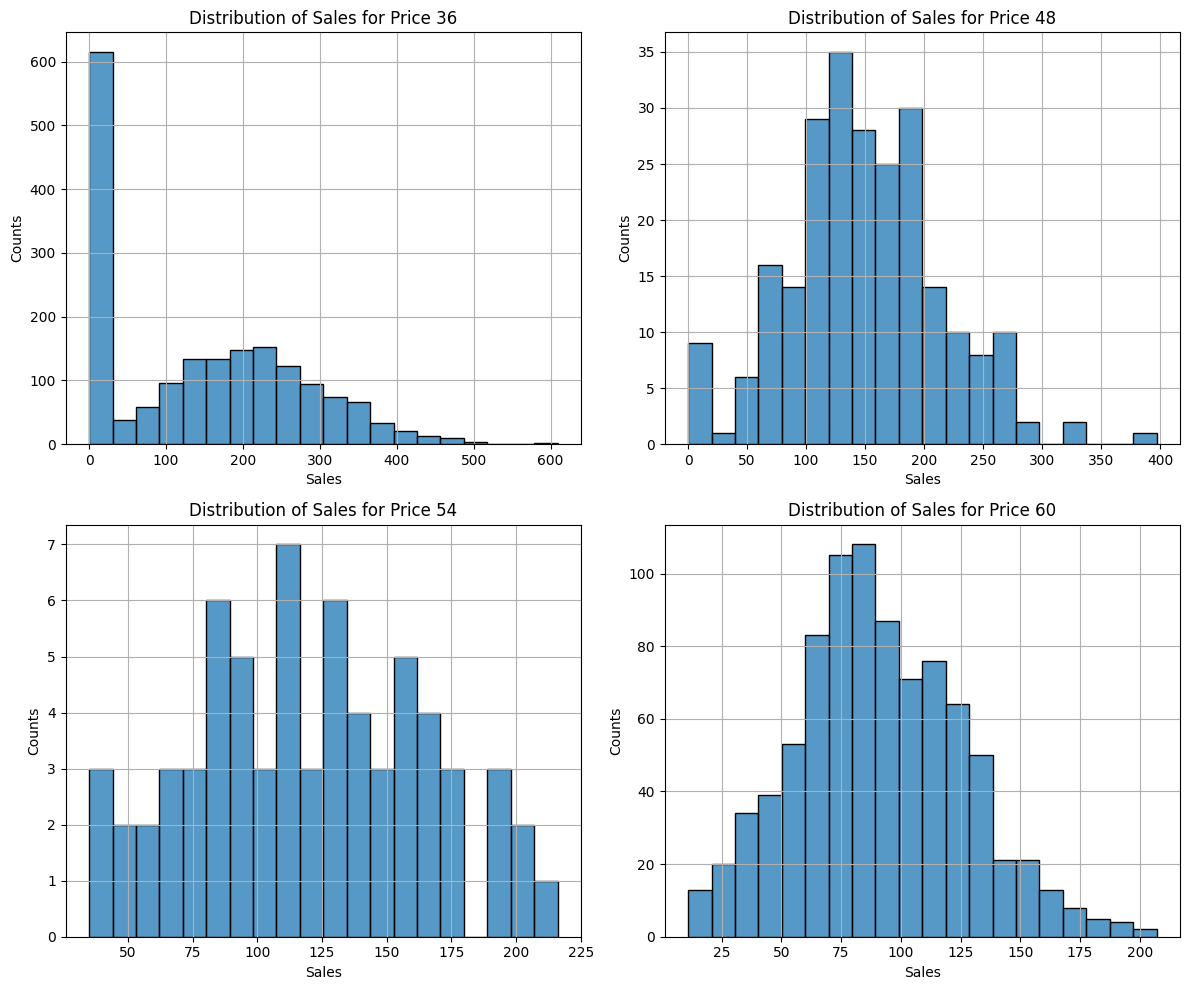

In [9]:
# Define the price points you want to analyze
price_points = [36, 48, 54, 60]

# Filter the dataset for the relevant price points
filtered_df = df[df['Price'].isin(price_points)]

# Plot the distribution of sales for each price point in separate plots
plt.figure(figsize=(12, 10))

for i, price in enumerate(price_points, 1):
    plt.subplot(2, 2, i)
    sns.histplot(filtered_df[filtered_df['Price'] == price]['Sales'], bins=20, kde=False)
    plt.title(f'Distribution of Sales for Price {price}')
    plt.xlabel('Sales')
    plt.ylabel('Counts')
    plt.grid(True)

plt.tight_layout()
plt.show()

Distribution of Sales for Price $36:

The sales distribution for the price of $36 shows a large number of weeks with very low sales (close to 0), and a peak around 100-150 sales. This indicates that while there were many weeks with low demand, there were also a significant number of weeks with moderate sales. The distribution is right-skewed, suggesting occasional high sales values up to around 600.

Distribution of Sales for Price $48:

For the price of $48, the distribution of sales is more concentrated around the 100-150 sales range, with a noticeable peak. The sales numbers are fairly spread out, indicating variability in demand at this price point. The distribution shows a slight right skew, with some weeks reaching sales up to 400.

Distribution of Sales for Price $54:

The sales distribution for the price of $54 shows a roughly uniform spread across the 50-200 sales range, with no single clear peak. This indicates consistent demand at this price level, with relatively even sales numbers across the different weeks. The distribution appears more symmetric compared to other price points.

Distribution of Sales for Price $60:

At the highest price of $60, the sales distribution shows a peak around 75-100 sales, with a sharp decline as sales numbers increase beyond this range. This suggests that higher prices significantly reduce the number of units sold. The distribution is left-skewed, indicating fewer weeks with high sales numbers and more weeks with lower sales.

In [10]:
# Average sales for each price point
avg_sales = filtered_df.groupby('Price')['Sales'].mean()
avg_sales

Price
36    144.808815
48    149.987500
54    119.676471
60     90.766249
Name: Sales, dtype: float64

Build Linear Model to predict the number of sales at a given week for a certain price

In [39]:
# Linear regression model 
import statsmodels.formula.api as smf

# Fit a linear regression model
lm = smf.ols(data=filtered_df, formula="Sales ~ Price").fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     147.7
Date:                Sun, 19 May 2024   Prob (F-statistic):           3.28e-33
Time:                        18:13:48   Log-Likelihood:                -18202.
No. Observations:                3000   AIC:                         3.641e+04
Df Residuals:                    2998   BIC:                         3.642e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    223.9891      8.057     27.801      0.0

In [44]:
lm.params

Intercept    223.989056
Price         -2.143431
dtype: float64

In [40]:
# Linear regression model 
import statsmodels.formula.api as smf

# Fit a linear regression model
lm1 = smf.ols(data=filtered_df, formula="Sales ~ Price + Week + Price:Week").fit()
print(lm1.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     781.4
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        18:13:55   Log-Likelihood:                -17408.
No. Observations:                3000   AIC:                         3.482e+04
Df Residuals:                    2996   BIC:                         3.485e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    995.5491     18.744     53.114      0.0

In [41]:
#Model Parameters
lm1.params

Intercept     995.549080
Price         -14.941824
Week          -67.183900
Price:Week      1.054515
dtype: float64

Second linear regression is better with Higher r2

Intercept (995.5491):

This is the baseline level of sales when both price and week are zero. Although these values are not practical, the intercept serves as a starting point for the model.
Price (-14.9418):

This coefficient indicates that for every one-unit increase in price, sales decrease by approximately 14.94 units, holding all other factors constant. This negative relationship is expected, as higher prices generally lead to lower sales.

Week (-67.1839):

This coefficient shows that for each additional week, sales decrease by about 67.18 units, assuming the price remains constant. This reflects the trend that sales tend to decline as the season progresses, likely due to reduced inventory or decreasing demand over time.

Price:Week Interaction (1.0545):

The interaction term between price and week suggests that the negative effect of price on sales diminishes slightly over time. Specifically, for each additional week, the impact of price on sales increases by 1.05 units. This means that as the weeks go by, higher prices have a slightly less negative impact on sales

## Linear Optimization

In [53]:
from gurobipy import Model, GRB, quicksum

# Extract coefficients from the regression model
intercept = lm1.params['Intercept']
price_coeff = lm1.params['Price']
week_coeff = lm1.params['Week']
interaction_coeff = lm1.params['Price:Week']

# Define parameters
weeks = 15
initial_inventory = 2000
prices = [60, 54, 48, 36]
price_index = {price: i for i, price in enumerate(prices)}

# Create a Gurobi model
m = Model("retail_pricing")

# Define decision variables
# X[p, w] is a binary variable indicating whether price p is chosen in week w
X = m.addVars(len(prices), weeks, vtype=GRB.BINARY, name="X")
S = m.addVar(name="Sales")

# Objective function: Maximize total revenue
revenue = quicksum(
    prices[i] * X[i, j] * (intercept + price_coeff * prices[i] + (week_coeff + interaction_coeff * prices[i]) * (j + 1))
    for i in range(len(prices)) for j in range(weeks)
)
m.setObjective(revenue, GRB.MAXIMIZE)

# Constraint: One price per week
m.addConstrs((quicksum(X[i, j] for i in range(len(prices))) == 1 for j in range(weeks)), name="PricePerWeek")

# Calculate total sales
total_sales = quicksum(
    X[i, j] * (intercept + price_coeff * prices[i] + (week_coeff + interaction_coeff * prices[i]) * (j + 1))
    for i in range(len(prices)) for j in range(weeks)
)
m.addConstr(S == total_sales)
m.addConstr(S <= initial_inventory, name="MaxSales")

# Constraint: Prices can only go down or remain the same
for j in range(1, weeks):
    for i in range(1, len(prices)):
        m.addConstr(quicksum(X[k, j] for k in range(i)) <= quicksum(X[k, j-1] for k in range(i)), name=f"NonIncreasingPrice_{i}_{j}")

# Constraint: The price in the first week must be $60
m.addConstr(X[price_index[60], 0] == 1, name="FirstWeekPrice60")

# Additional Constraint to manage inventory
#m.addConstr(S >=8*initial_inventory, name="MinSales")

# Optimize the model
m.optimize()

# Extract the solution if the model is optimal
if m.status == GRB.OPTIMAL:
    optimal_strategy = []
    week_sales = []
    for w in range(weeks):
        for i in range(len(prices)):
            if X[i, w].x > 0.5:
                optimal_strategy.append((w + 1, prices[i]))
                # Calculate and store the sales for this week
                sales_value = (intercept + price_coeff * prices[i] + (week_coeff + interaction_coeff * prices[i]) * (w + 1))
                week_sales.append(sales_value)

    # Print the optimal strategy
    print("Optimal Strategy:")
    for week, price in optimal_strategy:
        print(f"Week {week}: Price ${price}")

    # Print the sales for each week
    print("\nSales for each week:")
    for week, sales in enumerate(week_sales, 1):
        print(f"Week {week}: Sales {sales:.2f}")
    # Print the total sales
    print(f"\nTotal Sales: {S.x:.2f}")
    # Print the total revenue
    print(f"Total Revenue: {m.objVal:.2f}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60 rows, 61 columns and 291 nonzeros
Model fingerprint: 0x41b31aec
Variable types: 1 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [7e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 12 rows and 13 columns
Presolve time: 0.00s
Presolved: 48 rows, 48 columns, 214 nonzeros
Variable types: 0 continuous, 48 integer (48 binary)
Found heuristic solution: objective 60961.868119
Found heuristic solution: objective 81148.092235



Root relaxation: objective 9.748856e+04, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 97488.5574    0   27 81148.0922 97488.5574  20.1%     -    0s
H    0     0                    95434.655469 97488.5574  2.15%     -    0s

Explored 1 nodes (43 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 95434.7 81148.1 60961.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.543465546917e+04, best bound 9.543465546917e+04, gap 0.0000%
Optimal Strategy:
Week 1: Price $60
Week 2: Price $54
Week 3: Price $48
Week 4: Price $48
Week 5: Price $48
Week 6: Price $48
Week 7: Price $48
Week 8: Price $48
Week 9: Price $48
Week 10: Price $48
Week 11: Price $48
Week 12: Price $48
Week 13: Price $48
Week 14: Price $48
Week 15: Price $48

Sales for each week:
Week

The objective is to maximize total revenue by deciding the optimal price each week from a set of predefined prices ($60, $54, $48, $36). The optimization model is built using coefficients obtained from a linear regression model, which estimates sales based on price and week.

Constraints:

One price per week: Ensure only one price is chosen each week.
Total sales limit: Ensure total sales do not exceed the initial inventory (2000 units).
Non-increasing prices: Ensure prices do not increase over weeks.
First week price: Ensure the price in the first week is fixed at $60.

Optimization Results
The optimization process successfully found an optimal solution with the following key points:

Optimal Strategy: The optimal prices for each week, starting from $60 in the first week and then gradually decreasing to $48 from week 3 onward.
Sales for Each Week: Estimated sales for each week, starting with 95.13 units in week 1 and decreasing over time.
Total Sales: The total estimated sales over 15 weeks, amounting to 1943.41 units.
Total Revenue: The total revenue generated from the optimal pricing strategy, amounting to $95,434.66.